## Project: Titanic Survival Exploration

In 1912, the ship RMS Titanic struck an iceberg on its maiden voyage and sank, resulting in the deaths of most of its passengers and crew. In this project, we will explore a subset of the RMS Titanic passenger manifest to determine which features best predict whether someone survived or did not survive.

# Getting Started
To begin working with the RMS Titanic passenger data, we'll first need to `import` the functionality we need, and load our data into a `PySpark` DataFrame.  
Run the code cell below to load our data and display the first few entries (passengers) for examination using the `.show()` function.

In [1]:
# Import libraries necessary for this project
import seaborn as sns
from random import seed, choice
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Initialize Spark and SQL Contexts
spark_context = SparkContext()
sc = SQLContext(spark_context)

# Load the dataset
data = sc.read.csv('titanic_data.csv', header=True, inferSchema=True)

# Print the first few entries of the RMS Titanic data
data.show(20)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

From a sample of the RMS Titanic data, we can see the various features present for each passenger on the ship:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

To measure the performance of our predictions, we need a metric to score our predictions against the true outcomes of survival. Since we are interested in how *accurate* our predictions are, we will calculate the proportion of passengers where our prediction of their survival is correct. Run the code cell below to create our `accuracy_score` function and test a prediction on the first five passengers.  

**Think:** *Out of the first five passengers, if we predict that all of them survived, what would you expect the accuracy of our predictions to be?*

In [2]:
def accuracy_score(truth_and_preds):
    """ Returns accuracy score for input truth and predictions. """
    acc = (truth_and_preds.filter('class == predictions').count() / truth_and_preds.count()) * 100
    return "Predictions have an accuracy of {:.2f}%.".format(acc)

# Test the 'accuracy_score' function
seed('7777')
schema = StructType([StructField('class', IntegerType(), True), StructField('predictions', IntegerType(), True)])
predictions_df = sc.createDataFrame(spark_context.emptyRDD(), schema=schema)
for i in range(20):
    predictions_df = predictions_df.union(sc.createDataFrame([[choice([0,1]), choice([0, 1])]]))
predictions_df.show()
print(accuracy_score(predictions_df))

+-----+-----------+
|class|predictions|
+-----+-----------+
|    1|          0|
|    0|          0|
|    0|          0|
|    0|          1|
|    0|          1|
|    0|          1|
|    1|          1|
|    1|          1|
|    1|          1|
|    1|          1|
|    1|          0|
|    0|          1|
|    0|          1|
|    1|          0|
|    0|          0|
|    1|          0|
|    1|          1|
|    0|          0|
|    1|          1|
|    1|          0|
+-----+-----------+

Predictions have an accuracy of 50.00%.


# Making Predictions

If we were asked to make a prediction about any passenger aboard the RMS Titanic whom we knew nothing about, then the best prediction we could make would be that they did not survive. This is because we can assume that a majority of the passengers (more than 50%) did not survive the ship sinking.  
The `predictions_0` function below will always predict that a passenger did not survive.

In [3]:
def predictions_0(data_in):
    """ Model with no features. Always predicts a passenger did not survive. """
    return data_in.withColumn('predictions', lit(0))

# Make the predicitons
data_predictions = predictions_0(data)
predictions_df = data_predictions.selectExpr('Survived as class', 'predictions')

### Question 1
*Using the RMS Titanic data, how accurate would a prediction be that none of the passengers survived?*  
Run the code cell below to see the accuracy of this prediction.

In [4]:
print(accuracy_score(predictions_df))

Predictions have an accuracy of 61.62%.


**Answer:** *61.62%*

***
Let's take a look at whether the feature **Sex** has any indication of survival rates among passengers using the `survival_stats` function. This function is defined in the `visuals.py` Python script included with this project. The first two parameters passed to the function are the RMS Titanic data and passenger survival outcomes, respectively. The third parameter indicates which feature we want to plot survival statistics across.  
Run the code cell below to plot the survival outcomes of passengers based on their sex.

**NOTE:** The `PySpark` DataFrame has to be converted to a `Pandas` DataFrame inorder to be able to perform data visualizations.

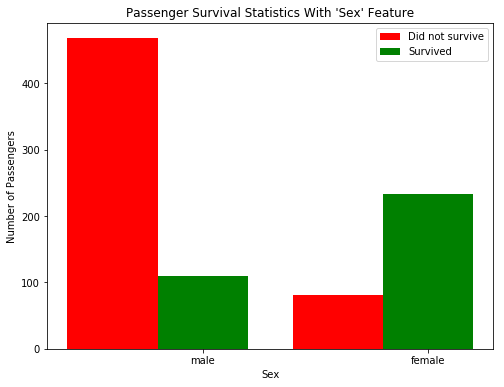

In [5]:
vs.survival_stats(data.drop('Survived').toPandas(), data.select('Survived').toPandas()['Survived'], 'Sex')

Examining the survival statistics, a large majority of males did not survive the ship sinking. However, a majority of females *did* survive the ship sinking. Let's build on our previous prediction: If a passenger was female, then we will predict that they survived. Otherwise, we will predict the passenger did not survive.  

In [6]:
def predictions_1(data_in):
    """ Model with no features. Always predicts a passenger did not survive. """
    check_sex_udf = udf(lambda sex: 1 if sex == 'female' else 0, IntegerType())
    return data_in.withColumn('predictions', check_sex_udf(data_in['Sex']))

# Make the predicitons
data_predictions = predictions_1(data)
predictions_df = data_predictions.selectExpr('Survived as class', 'predictions')

### Question 2
*How accurate would a prediction be that all female passengers survived and the remaining passengers did not survive?*  
Run the code cell below to see the accuracy of this prediction.

In [7]:
print(accuracy_score(predictions_df))

Predictions have an accuracy of 78.68%.


**Answer**: *78.68%*

In [8]:
spark_context.stop()